In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

sns.set_theme(style="whitegrid")


In [2]:
# DETECTIONS = "object_detection_scripts/3_prediction_pipeline_postprocessing/post_process_detections/output/2023/Astoria_08_August-no-dup/snb5_cn_hg_v9"
DETECTIONS = 'object_detection_scripts/3_prediction_pipeline_postprocessing/post_process_detections/output/2023/Astoria_08_August/snb5_cn_hg_v9'
DETECTIONS = Path(DETECTIONS)
AMBPano = [
    'AMBPano1',
    'AMBPano2',
    'AMBPano3',
    'AMBPano4',
    'AMBPano5',
    'AMBPano6',
    'AMBPano7',
    'AMBPano8',
    'AMBPano9'
]

In [3]:
def filter_detections(detections, threshold_dict={}):
    for label, thresh in threshold_dict.items():
        detections = detections[(detections['detection_classes'] != label) |
                                ((detections['detection_classes'] == label) &
                                 (detections['detection_scores'] >= thresh))]
    return detections

In [4]:
# develop single instance
threshold_dict = {0.0: 0.2, 1.0: 0.2} # 0: Cormorants, 1: Nest
detections = pd.read_csv(DETECTIONS / AMBPano[0] / "post_processed_detections_masked.csv")
# detections = pd.read_csv(detections_file)
total = detections['detection_classes'].value_counts(ascending=False)
total.name = 'total'
detections = filter_detections(detections, threshold_dict)
filt = detections['detection_classes'].value_counts(ascending=False)
filt.name = "filt"
# detections
total = total-filt
total.name = 'missed'
dp = pd.DataFrame([filt, total])
# dp['detections'] = filt
# dp['detections_under_threshold'] = total-filt
dp


,0.0,1.0
filt,103,17
missed,23,13


In [5]:
accum = {}
for name in AMBPano:
    detections_file = DETECTIONS / name / "post_processed_detections_masked.csv"
    
    detections = pd.read_csv(detections_file)
    total = detections['detection_classes'].value_counts(ascending=False)

    detections = filter_detections(detections, threshold_dict) # filter for thresholds
    threshold_det = detections['detection_classes'].value_counts(ascending=False)
    threshold_det.name = 'detections'
    
    total = total - threshold_det
    total.name = 'detections_under_threshold'

    dp = pd.DataFrame([threshold_det, total]).T
    # dp['detections'] = threshold_det
    # dp['detections_under_threshold'] = total
    
    accum.update({name: dp})
    print(dp)


     detections  detections_under_threshold
0.0         103                          23
1.0          17                          13
     detections  detections_under_threshold
0.0          93                          32
1.0           7                           4
     detections  detections_under_threshold
0.0          95                          40
1.0          15                          11
     detections  detections_under_threshold
0.0          21                           6
1.0           5                           3
     detections  detections_under_threshold
1.0          43                          42
0.0          36                          27
     detections  detections_under_threshold
0.0          25                          12
1.0          14                           9
     detections  detections_under_threshold
0.0          30                          28
1.0          19                          40
     detections  detections_under_threshold
0.0          73                 

In [6]:
df = pd.concat(accum.values(), keys=accum.keys(), names=['Image Name', 'Class'])
df.head(5)

detections  detections_under_threshold
Image Name Class                                        
AMBPano1   0.0           103                          23
           1.0            17                          13
AMBPano2   0.0            93                          32
           1.0             7                           4
AMBPano3   0.0            95                          40

In [7]:
# df2.reset_index().pivot(index='Image Name', columns='Class', values=['detections', 'detections_under_threshold'])


In [8]:
# df2 = df.to_frame()
df2 = df.copy()
# df2.columns=['Model Detections']
df2

df3 = df2.reset_index('Class')
df3['Class'] = df3['Class'].replace({
    0.0: 'Cormorants',
    1.0: 'Nests'
})
df3.head(5)
df3
df3 = df3.reset_index() #.pivot(index='Image Name', columns='Class', values=['detections', 'detections_under_threshold'])
df3.head(5) #.reset_index()


,Image Name,Class,detections,detections_under_threshold
0,AMBPano1,Cormorants,103,23
1,AMBPano1,Nests,17,13
2,AMBPano2,Cormorants,93,32
3,AMBPano2,Nests,7,4
4,AMBPano3,Cormorants,95,40


In [9]:
#pd.read_csv('2023/Astoria_08_August/snb5_cn_hg_v9/detection_counts_0.csv');

## Advanced plotting

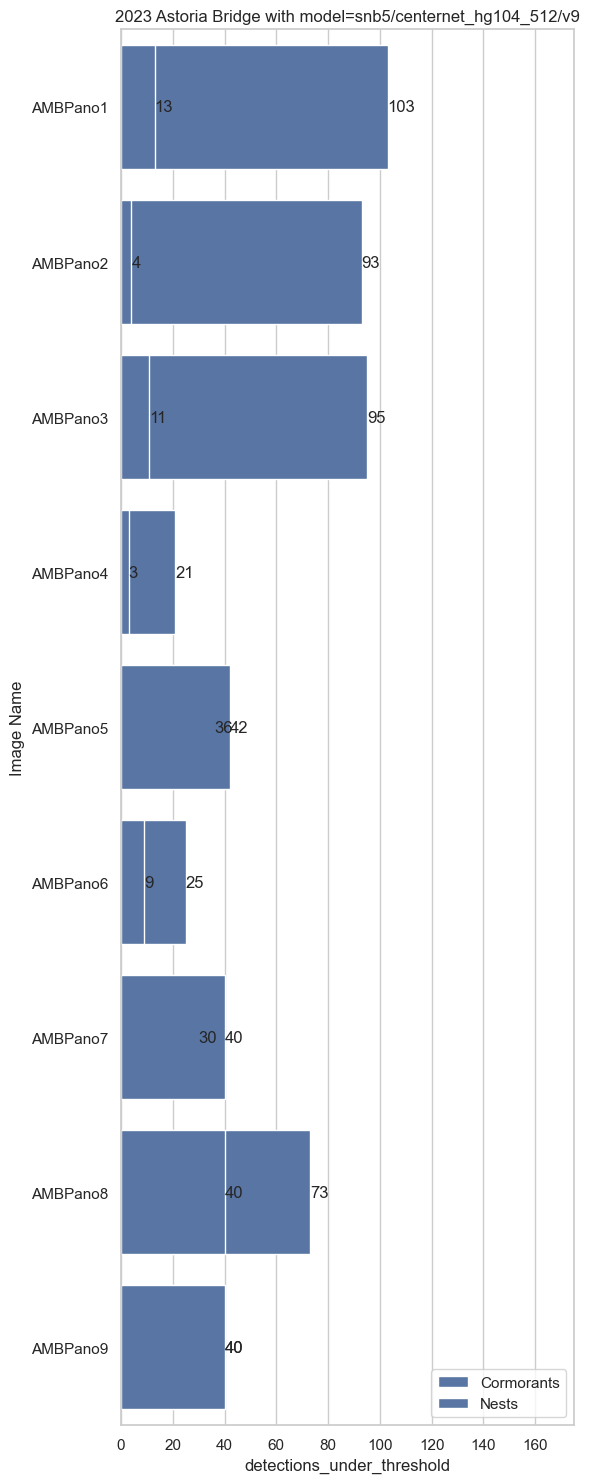

In [10]:
# df3.plot.bar();

model = "snb5/centernet_hg104_512/v9"
# ax = sns.barplot(x='Model Detections', 
#                  y='Image Name', 
#                  data=df3.reset_index(), 
#                  hue='Class', 
#                  orient = 'h', 
#                 )

data = df3.reset_index()
cond = data['Class'] == 'Cormorants'
cols = ['Image Name', 'Class'] 
data_detect = data.loc[cond, cols + ['detections'] ]

cond = data['Class'] == 'Nests'
data_detect_under = data.loc[cond, cols + ['detections_under_threshold'] ]

f, ax = plt.subplots(figsize=(6, 15))

# sns.set_color_codes()
sns.color_palette()
sns.barplot(x='detections', 
            y="Image Name", 
            data=data_detect,
            hue='Class', 
            # color="b", 
            orient='h', 
            errorbar=None)

# sns.set_color_codes("muted")
# sns.color_palette("pastel")
# sns.set_color_codes("pastel")
sns.color_palette("pastel")
sns.barplot(x="detections_under_threshold", 
            y="Image Name", 
            data=data_detect_under,
            hue='Class', 
            # color="b", 
            orient='h', 
            errorbar=None)

for bc in ax.containers: # add labels to all bars
    ax.bar_label( bc );

xlim = ax.get_xlim()
xlim = xlim[0], 175

ax.set_xlim(xlim);
ax.legend(loc="lower right", frameon=True);
ax.set_title(f"2023 Astoria Bridge with model={model}");
fig = ax.get_figure()



## Plot

In [11]:
data = df3.set_index('Image Name')
cond = data['Class'] == 'Cormorants'

cormorants = data.loc[cond].drop(columns='Class')
cormorants

cond = data['Class'] == 'Nests'
nests = data.loc[cond].drop(columns='Class')
nests

cormorants
nests

,detections,detections_under_threshold
Image Name,,
AMBPano1,17,13
AMBPano2,7,4
AMBPano3,15,11
AMBPano4,5,3
AMBPano5,43,42
AMBPano6,14,9
AMBPano7,19,40
AMBPano8,29,40
AMBPano9,34,40


In [12]:
CLASS = 'Cormorants'
CLASS = 'Nests'

title = f"2023 Astoria Bridge with model={model}"
subtitle = ""
if CLASS == 'Cormorants':
    target = cormorants
    subtitle += f"{CLASS} | {threshold_dict[0.0]} threshold"
    
if CLASS == 'Nests':
    target = nests
    subtitle += f"{CLASS} | {threshold_dict[1.0]} threshold"

target_data = target.stack().reset_index()
target_data.columns=['Image Name', 'detections', 'num']
target_data

,Image Name,detections,num
0,AMBPano1,detections,17
1,AMBPano1,detections_under_threshold,13
2,AMBPano2,detections,7
3,AMBPano2,detections_under_threshold,4
4,AMBPano3,detections,15
5,AMBPano3,detections_under_threshold,11
6,AMBPano4,detections,5
7,AMBPano4,detections_under_threshold,3
8,AMBPano5,detections,43
9,AMBPano5,detections_under_threshold,42


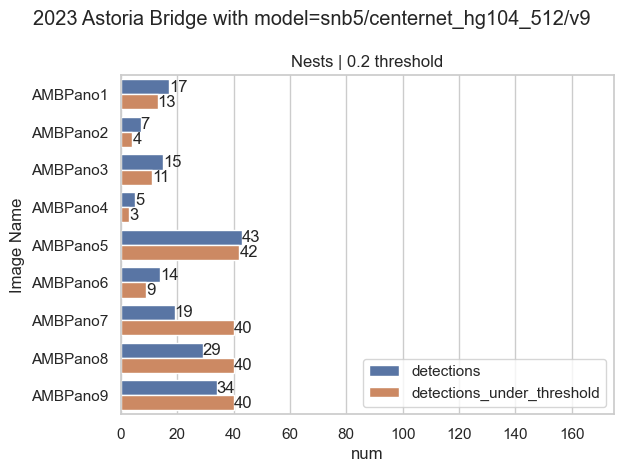

In [13]:
# df3.plot.bar();

model = "snb5/centernet_hg104_512/v9"
ax = sns.barplot(
                 x='num', 
                 y='Image Name', 
                #  data=df3.reset_index(), 
                 data=target_data,
                 hue='detections', 
                 orient = 'h', 
                 errorbar = None
                )

for bc in ax.containers: # add labels to all bars
    ax.bar_label( bc );

xlim = ax.get_xlim()
xlim = xlim[0], 175

ax.set_xlim(xlim);
ax.legend(loc="lower right", frameon=True);
ax.set_title(subtitle);

fig = ax.get_figure()
fig.suptitle(title);


## Save

In [14]:
SAVE = True
VER = '_dupsmerge_0'
CLASS = CLASS
OUTFILE = "2023/Astoria_08_August/snb5_cn_hg_v9/detection_counts" + "_" + CLASS + VER

if SAVE is True:
    fig.savefig(OUTFILE + '.png') 
    df3.to_csv(OUTFILE + '.csv', index=False)
        

In [15]:
# Seaborn, horizontal bar plots
# https://seaborn.pydata.org/examples/part_whole_bars.html

## Advanced Plotting

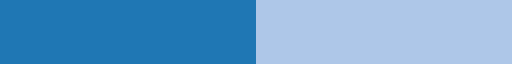

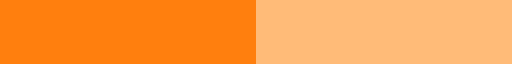

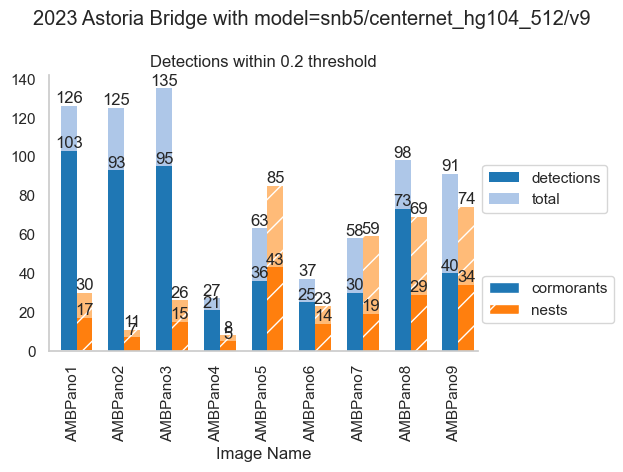

In [26]:

data = df3.set_index('Image Name')
data.columns = ['Class', 'detections', 'total']
cond = data['Class'] == 'Cormorants'

cormorants = data.loc[cond].drop(columns='Class')
cormorants

cond = data['Class'] == 'Nests'
nests = data.loc[cond].drop(columns='Class')
nests

subtitle = "Detections within 0.2 threshold"
ax = plot_clustered_stacked([cormorants, nests], ["cormorants", "nests"], title=f"2023 Astoria Bridge with model={model}");

cormorants, nests

fig = ax.get_figure()
fig.savefig(OUTFILE + 'stacked.png') 


In [23]:
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
tab20 = mpl.colormaps['tab20'] #.resampled(2)
tab10 = mpl.colormaps['tab10']
gradient_base = tab20

rcParams.update({'figure.autolayout': True})

sns.set_theme(style="whitegrid")


def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

# Create a custom colormap

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    step=2
    cmaps_base = tab10 # Unique colors also in gradient_base 
    gradient_base = tab20 # gradient_base(tab20) contains start/end colors

    # assert n_df <= tab20.N/2
    if n_df >= gradient_base.N/2 :
        print(f"Too many dataframes ({n_df}) for the selected colors {gradient_base.N/2}. The chart may not look good.")
        print("Selecting from tab20:")
        display(gradient_base)

    cmaps = []
    for i, lab in enumerate(labels): # create a color map for each dataframe
        # To create a gradient, select indices to start (i*2) and end colors (i*2+step) from tab20
        # Gradiate `n_col` number of shades between start:end
        cm = mcolors.LinearSegmentedColormap.from_list(f"Custom-{lab}", gradient_base.colors[i*2: i*2+step], N=n_col)
        display(cm)
        cmaps.append(cm)
    
    for df, cm in zip(dfall, cmaps) : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      colormap = cm,
                      **kwargs)  # make bar plots
    

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))


    # axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    # axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(subtitle)
    sns.despine()

    for bar_values in axe.containers: # add labels to all bars
        axe.bar_label( bar_values )


    # Add invisible data to add another legend
    n=[]        
    for i, cm in enumerate(cmaps_base.colors):
        n.append(axe.bar(0, 0, color=cm, hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)

    fig = axe.get_figure()
    fig.suptitle(title);
    # fig.savefig(OUTFILE + 'stacked.png') 
    return axe

# create fake dataframes
# df1 = pd.DataFrame(np.random.rand(4, 5),
#                    index=["A", "B", "C", "D"],
#                    columns=["I", "J", "K", "L", "M"])
# df2 = pd.DataFrame(np.random.rand(4, 5),
#                    index=["A", "B", "C", "D"],
#                    columns=["I", "J", "K", "L", "M"])
# df3 = pd.DataFrame(np.random.rand(4, 5),
#                    index=["A", "B", "C", "D"], 
#                    columns=["I", "J", "K", "L", "M"])


In [24]:
mpl.__version__


'3.7.1'

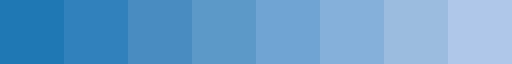

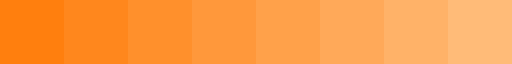

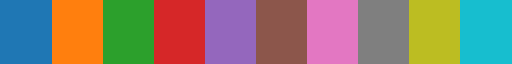

In [25]:
import matplotlib as mpl
# from matplotlib.colors import LinearSegmentedColormap, ListedColormap

gradient_base = mpl.colormaps['tab20'] #.resampled(2)
gradient_base

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = list(mcolors.TABLEAU_COLORS.values())[0:8]

# Create a custom colormap
N=2
i=2
ndf=2
ncols = 8
for i in range(0, ndf):
    cmap = mcolors.LinearSegmentedColormap.from_list("Custom", gradient_base.colors[i*2: i*2+N], N=ncols)
    display(cmap)

# mcolors.ListedColormap()
# mcolors.TABLEAU_COLORS.values()
# tab20.colors
# tab20
gradient_base
mpl.colormaps['tab10'] #.resampled(2)
